In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [2]:
%matplotlib inline

import itertools
from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from scipy import stats
from scipy import signal
from sklearn import decomposition
from sklearn.cluster import DBSCAN
from behavior import get_extent, density_map, get_idxs_behav_state
from spatial import gaussian_kernel_2D, get_field_patches
from matplotlib.lines import Line2D

from population import unit_response_matrix, activity_at_phase

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [ ]:
selected = [
    "57_SIT_2023-12-22_14-08-07",  # good
    "57_SIT_2023-12-22_14-43-58",  # good
    "57_SIT_2023-12-22_17-37-18",
    "57_SIT_2023-12-28_16-43-28",  # good
    "57_SIT_2023-12-29_11-06-26",  # good
    "57_SIT_2023-12-29_11-40-14",  # good
    "57_SIT_2023-12-29_12-11-46",
    "57_SIT_2024-01-02_14-43-18",
    "57_SIT_2024-01-02_16-38-05",  # good
    "57_SIT_2024-01-02_17-10-09",
    "57_SIT_2024-01-03_19-22-18",  # good
    "57_SIT_2024-01-03_19-54-59",
    "57_SIT_2024-01-04_14-16-22",
    "57_SIT_2024-01-04_14-52-59",
    "57_SIT_2024-01-05_14-35-49",  # good
    "57_SIT_2024-01-05_15-08-34",
    "57_SIT_2024-01-06_16-52-40",
    "57_SIT_2024-01-06_17-25-35",  # good
    "57_SIT_2024-01-07_19-23-28",
    "57_SIT_2024-01-07_19-59-26",
    "57_SIT_2024-01-08_15-51-26",
    "57_SIT_2024-01-15_13-45-22",
    "57_SIT_2024-01-15_14-34-48",
    "57_SIT_2024-02-01_15-51-41",
    "57_SIT_2024-02-05_13-10-00"
]

In [19]:
#source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
rep_path = '/home/sobolev/nevermind/Andrey/analysis/manuscripts/'

sessions = [s for s in selected_009266.keys()]
sessions = [s for s in selected_009265.keys()]
#sessions = [s for s in selected_008229.keys()]
sessions.sort()

selected = sessions[:]

# showcase
selected = [
    '009266_hippoSIT_2023-04-20_08-57-39',
    '009266_hippoSIT_2023-05-04_19-47-15',
    '009266_hippoSIT_2023-04-17_17-04-17',
    '009266_hippoSIT_2023-05-23_09-18-05',
]
selected

['009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-05-23_09-18-05']

## Density plots

https://matplotlib.org/2.0.2/examples/pylab_examples/contour_demo.html

https://matplotlib.org/stable/users/explain/colors/colormaps.html


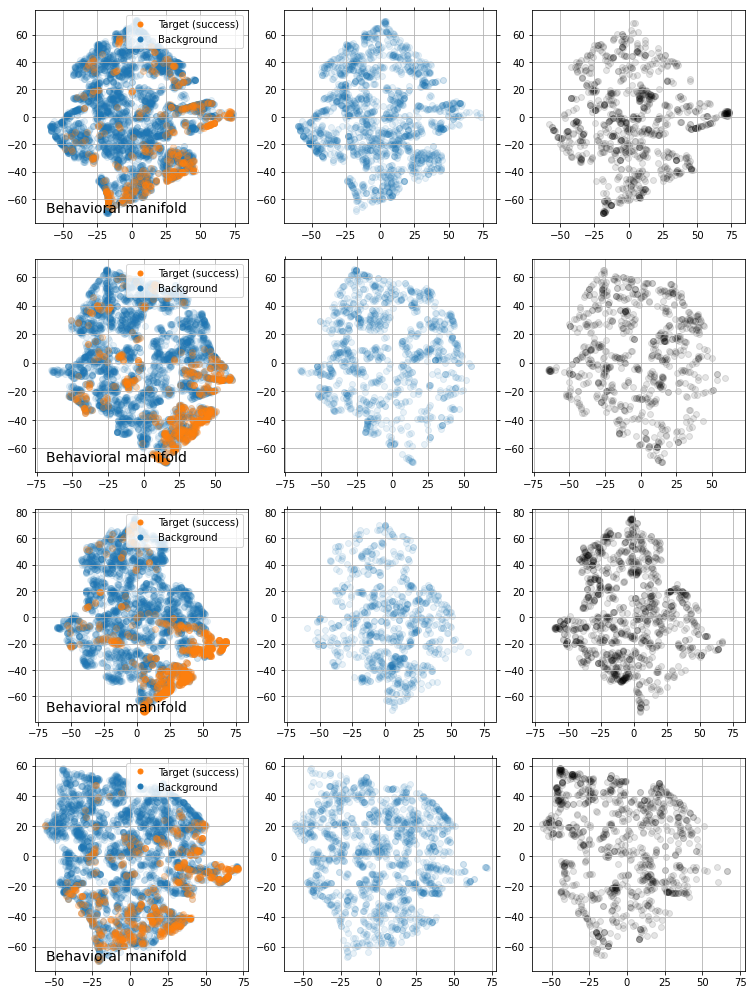

In [18]:
fit_type = 'tSNE'
fit_parm = 70
speed_thresh = 0.04  # m/s
sigma = 0.3
margin = 5
#fit_type = 'UMAP'
#fit_parm = 0.5
titles = ['Sound state', 'Background\n(stationary only)', 'No stimulus\n(stationary only)']
#titles = ['Sound state', 'Sucessful target', 'Background only', 'Silence only']
rows = len(selected)
cols = 3
size = 3.5
fig, axes = plt.subplots(rows, cols, figsize=(size*cols, size*rows))

for i, session in enumerate(selected):
    animal = session.split('_')[0]
    s_path           = os.path.join(source, animal, session)
    meta_file        = os.path.join(source, animal, session, 'meta.h5')
    moseq_class_file = os.path.join(source, animal, session, 'analysis', 'MoSeq_tSNE_UMAP.h5')
    desc_file  = os.path.join(source, animal, session, 'descendants.h5')
    
    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
    with h5py.File(moseq_class_file, 'r') as f:
        idxs_srm_tl = np.array(f['idxs_srm_tl'])
        fit = np.array(f[fit_type][str(fit_parm)])
    with h5py.File(desc_file, 'r') as f:
        speed = np.array(f['speed'])
        hd    = np.array(f['hd'])
        
    idxs_srm_succ = []
    for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
        tl_l, tl_r = tgt_rec[2], tgt_rec[3]
        idxs_srm_succ += list(np.where((idxs_srm_tl > tl_l) & (idxs_srm_tl < tl_r))[0])
        
    idxs_sta_ev  = np.where(speed[events[:, 2].astype(np.int32)] < speed_thresh)[0]  # define speed filter here
    idxs_srm_sta = np.unique(np.round(idxs_sta_ev/2).astype(np.int32))  # TODO: bring behavior to the same sampling!
    idxs_srm_bgr = np.where(tl[idxs_srm_tl][:, 6] == 1)[0]
    idxs_srm_sil = np.where(tl[idxs_srm_tl][:, 6] == 0)[0]
    idxs_srm_tgt = np.where(tl[idxs_srm_tl][:, 6] == 2)[0]
    
    idxs_srm_bgr_sta = np.intersect1d(idxs_srm_bgr, idxs_srm_sta)
    idxs_srm_sil_sta = np.intersect1d(idxs_srm_sil, idxs_srm_sta)

    extent = get_extent(fit, margin=margin)
    b_size = extent[1] - extent[0]
    
    # fit contours
    d_map  = density_map(fit, extent, sigma=sigma, bin_count=100)
    levels = np.linspace(0.15*d_map.max(), d_map.max(), 2)
    CS_fit = axes[i][1].contour(d_map.T, levels, origin='lower', linewidths=2, extent=extent)

    # success contours
    d_map   = density_map(fit[idxs_srm_succ], extent, sigma=sigma, bin_count=100)
    levels  = np.linspace(0.25*d_map.max(), d_map.max(), 2)
    CS_succ = axes[i][1].contour(d_map.T, levels, origin='lower', linewidths=2, extent=extent)
    
    bgr_sta_map = density_map(fit[idxs_srm_bgr_sta], extent, sigma=sigma, bin_count=100)
    sil_sta_map = density_map(fit[idxs_srm_sil_sta], extent, sigma=sigma, bin_count=100)
    
    axes[i][1].clear()  # clear axes from original contours
    #ctrs = measure.find_contours(d_map, 0.25)
    
    ax = axes[i][0]
    #ax.scatter(fit[:, 0], fit[:, 1], alpha=0.02, color='black')
    ax.scatter(fit[idxs_srm_bgr][:, 0], fit[idxs_srm_bgr][:, 1], alpha=0.1, color='tab:blue')
    #ax.scatter(fit[idxs_srm_tgt][:, 0], fit[idxs_srm_tgt][:, 1], alpha=0.25, color='tab:orange')
    ax.scatter(fit[idxs_srm_succ][:, 0], fit[idxs_srm_succ][:, 1], alpha=0.25, color='tab:orange')
    #ax.set_ylabel(session[-19:-6], fontsize=14)
    legend_elements = [
        Line2D([0], [0], marker='.', linestyle='None', color='tab:orange', markersize=10, label='Target (success)'),
        Line2D([0], [0], marker='.', linestyle='None', color='tab:blue', markersize=10, label='Background')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
        
    #ax = axes[i][1]
    #ax.imshow(d_map.T, cmap='Greens', origin='lower', extent=extent)
    #ax.scatter(fit[idxs_AL_srm][:, 0], fit[idxs_AL_srm][:, 1])
    #for path in CS_succ.collections[0].get_paths():
    #    verts = path.vertices
    #    ax.plot(verts[:,0], verts[:,1], color='green', lw=2)
    
    ax = axes[i][1]
    ax.scatter(fit[idxs_srm_bgr_sta][:, 0], fit[idxs_srm_bgr_sta][:, 1], alpha=0.1, color='tab:blue')
    #ax.imshow(bgr_sta_map.T, cmap='Blues', origin='lower', extent=extent)

    ax = axes[i][2]
    ax.scatter(fit[idxs_srm_sil_sta][:, 0], fit[idxs_srm_sil_sta][:, 1], alpha=0.1, color='black')
    #ax.imshow(sil_sta_map.T, cmap='Greys', origin='lower', extent=extent)

    for j, ax in enumerate(axes[i]):
        ax.grid()
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
        ax.set_aspect('equal')
        #if i == 0:
        #    ax.set_title(titles[j], fontsize=14)
        if j < 1:
            ax.text(extent[0] + 0.05*b_size, extent[2] + 0.05*b_size, 'Behavioral manifold', fontsize=14)

        # whole fit
        #for path in CS_fit.collections[0].get_paths():
        #    verts = path.vertices
        #    ax.plot(verts[:,0], verts[:,1], ls='--', color='tab:blue')
        # successful target
        #for path in CS_succ.collections[0].get_paths():
        #    verts = path.vertices
        #    ax.plot(verts[:,0], verts[:,1], color='black', ls='--')
        
fig.tight_layout()

In [21]:
fig.savefig(os.path.join(rep_path, '%s_bMAP.png' % sessions[0][-19:-6]), dpi=300)

## Non-exclusive behavioral states

In [54]:
def get_points_inside_paths(paths, all_points):
    all_in = None
    for c_path in paths:
        p_in = all_points[c_path.contains_points(all_points)]
        if all_in is None:
            all_in = p_in.copy()
        else:
            all_in = np.concatenate([all_in, p_in])
            
    return all_in

In [55]:
def intersect_2D(p_A, p_B):
    pA_set = set([tuple(x) for x in p_A])
    pB_set = set([tuple(x) for x in p_B])
    return np.array([x for x in pA_set & pB_set])
    
def union_2D(p_A, p_B):
    p_union = np.concatenate([p_A, p_B])
    return np.unique(p_union, axis=0)

def setdiff_2D(p_A, p_B):
    pA_set = set([tuple(x) for x in p_A])
    pB_set = set([tuple(x) for x in p_B])
    return np.array([x for x in pA_set.difference(pB_set)])

In [102]:
fit_type = 'tSNE'
fit_parm = 70
speed_thresh = 0.04  # m/s
sigma = 0.3
margin = 5
bin_count = 100
cmaps = ['Greys', 'Blues']
#fit_type = 'UMAP'
#fit_parm = 0.5

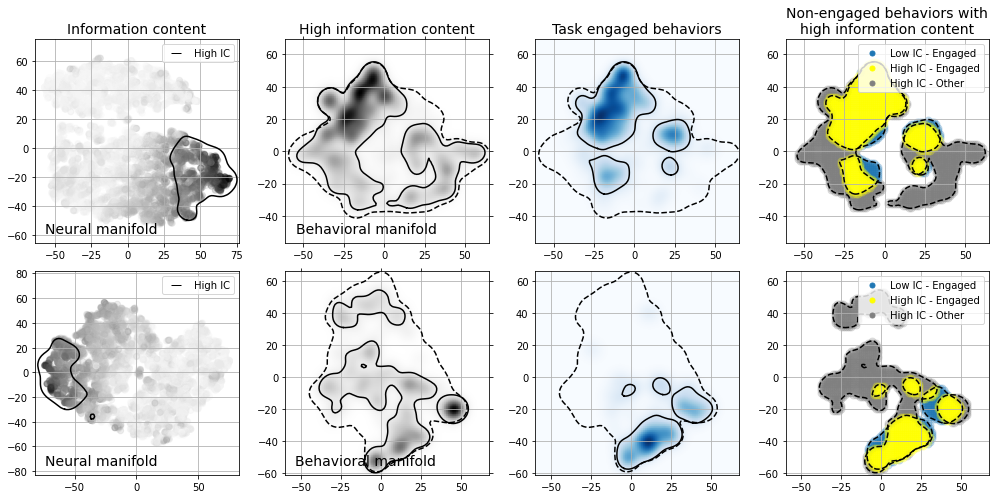

In [115]:
titles = [
    'Information content',
    'High information content',
    'Task engaged behaviors', 
    'Non-engaged behaviors with\nhigh information content'
]
rows = len(selected)
cols = 4
size = 3.5
fig, axes = plt.subplots(rows, cols, figsize=(size*cols, size*rows))

areas = np.zeros([len(selected), 4])  # bE, bU, overlap, all
for i, session in enumerate(selected):
    animal = session.split('_')[0]
    s_path           = os.path.join(source, animal, session)
    meta_file        = os.path.join(source, animal, session, 'meta.h5')
    umap_file        = os.path.join(source, animal, session, 'analysis', 'W1-W4_tSNE_UMAP.h5')
    moseq_class_file = os.path.join(source, animal, session, 'analysis', 'MoSeq_tSNE_UMAP.h5')
    desc_file        = os.path.join(source, animal, session, 'descendants.h5')
    state_file       = os.path.join(source, animal, session, 'analysis', 'state_idxs.h5')
    
    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
    with h5py.File(moseq_class_file, 'r') as f:
        idxs_srm_tl = np.array(f['idxs_srm_tl'])
        b_fit = np.array(f[fit_type][str(fit_parm)])
    with h5py.File(umap_file, 'r') as f:
        n_fit = np.array(f[fit_type][str(fit_parm)])
    with h5py.File(desc_file, 'r') as f:
        speed = np.array(f['speed'])
        hd    = np.array(f['hd'])
    with h5py.File(state_file, 'r') as f:
        idxs_AL_ev = np.array(f['idxs_AL_ev'])  # bAL state
        
    idxs_srm_succ = []
    for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
        tl_l, tl_r = tgt_rec[2], tgt_rec[3]
        idxs_srm_succ += list(np.where((idxs_srm_tl > tl_l) & (idxs_srm_tl < tl_r))[0])
        
    idxs_sta_ev  = np.where(speed[events[:, 2].astype(np.int32)] < speed_thresh)[0]  # define speed filter here
    idxs_srm_sta = np.unique(np.round(idxs_sta_ev/2).astype(np.int32))  # TODO: bring behavior to the same sampling!
    idxs_srm_bgr = np.where(tl[idxs_srm_tl][:, 6] == 1)[0]
    idxs_srm_sil = np.where(tl[idxs_srm_tl][:, 6] == 0)[0]
    idxs_srm_tgt = np.where(tl[idxs_srm_tl][:, 6] == 2)[0]
    
    idxs_srm_bgr_sta = np.intersect1d(idxs_srm_bgr, idxs_srm_sta)
    idxs_srm_sil_sta = np.intersect1d(idxs_srm_sil, idxs_srm_sta)

    idxs_AL_srm = np.unique(np.round(idxs_AL_ev/2).astype(np.int32))
    idxs_AL_bgr_srm = np.intersect1d(idxs_srm_bgr, idxs_AL_srm)

    # compute SNR
    times_to_event = [15, 28, 73, 100]
    bins, unit_mx = unit_response_matrix(s_path, [1, 2], times_to_event=times_to_event)

    sig = unit_mx[1::len(times_to_event) + 1].mean(axis=1) * (250/13) # norm by window size
    noi = unit_mx[4::len(times_to_event) + 1].mean(axis=1) * (250/150) # norm by window size

    k_width = 30
    kernel = signal.gaussian(k_width, std=(k_width) / 7.2)
    sig_sm = np.convolve(sig, kernel, 'same') / kernel.sum()
    noi_sm = np.convolve(noi, kernel, 'same') / kernel.sum()

    snr = np.ones(len(sig_sm))
    #idxs_noi_non_zero = np.where(noi_sm != 0)[0]
    #snr[idxs_noi_non_zero] = ((np.abs(sig_sm - noi_sm) + noi_sm)/noi_sm)[idxs_noi_non_zero]
    #snr[idxs_noi_non_zero] = (np.abs(sig_sm - noi_sm)/noi_sm)[idxs_noi_non_zero]
    snr = (np.abs(sig_sm - noi_sm) + noi_sm)/noi_sm

    snr_thresh = 0.6*np.log(snr).max()
    idxs_high_snr_ev  = np.where(np.log(snr) > snr_thresh)[0]
    idxs_high_snr_srm = np.where(np.log(snr[::2]) > snr_thresh)[0]
    
    # pop response at phase
    #w1 = activity_at_phase(s_path, phase=1, do_pca=True, k_width=30)
    #w4 = activity_at_phase(s_path, phase=4, do_pca=True, k_width=30)
    
    # ----------- CONTOURS -------------
    
    b_extent = get_extent(b_fit, margin=margin)
    bb_size = b_extent[1] - b_extent[0]
    n_extent = get_extent(n_fit, margin=margin)
    bn_size = n_extent[1] - n_extent[0]
    
    d_map  = density_map(n_fit[idxs_high_snr_ev], n_extent, sigma=sigma, bin_count=100)
    levels = np.linspace(0.15*d_map.max(), d_map.max(), 2)
    CS_n_high_snr = axes[i][1].contour(d_map.T, levels, origin='lower', linewidths=2, extent=n_extent)

    points_inside = []
    x_dim = np.linspace(b_extent[0], b_extent[1], bin_count)
    y_dim = np.linspace(b_extent[2], b_extent[3], bin_count)
    all_points = np.array([(x, y) for x, y in itertools.product(x_dim, y_dim)])

    # fit high SNR contours
    b_snr_map  = density_map(b_fit[idxs_high_snr_srm], b_extent, sigma=sigma, bin_count=100)
    levels = np.linspace(0.15*b_snr_map.max(), d_map.max(), 2)
    CS_high_snr = axes[i][1].contour(b_snr_map.T, levels, origin='lower', linewidths=2, extent=b_extent)
    points_inside.append(get_points_inside_paths(CS_high_snr.collections[0].get_paths(), all_points))

    # fit behav contours
    d_map  = density_map(b_fit, b_extent, sigma=sigma, bin_count=100)
    levels = np.linspace(0.15*d_map.max(), d_map.max(), 2)
    CS_b_fit = axes[i][1].contour(d_map.T, levels, origin='lower', linewidths=2, extent=b_extent)
    
    # success contours
    d_map   = density_map(fit[idxs_srm_succ], b_extent, sigma=sigma, bin_count=100)
    levels  = np.linspace(0.25*d_map.max(), d_map.max(), 2)
    CS_succ = axes[i][1].contour(d_map.T, levels, origin='lower', linewidths=2, extent=b_extent)
    
    # AL contours
    AL_b_map  = density_map(b_fit[idxs_AL_bgr_srm], b_extent, sigma=sigma, bin_count=100)
    levels = np.linspace(0.15*AL_b_map.max(), AL_b_map.max(), 2)
    CS_AL_b_fit = axes[i][1].contour(AL_b_map.T, levels, origin='lower', linewidths=2, extent=b_extent)
    points_inside.append(get_points_inside_paths(CS_AL_b_fit.collections[0].get_paths(), all_points))

    bgr_sta_map = density_map(fit[idxs_srm_bgr_sta], b_extent, sigma=sigma, bin_count=100)
    sil_sta_map = density_map(fit[idxs_srm_sil_sta], b_extent, sigma=sigma, bin_count=100)
    
    axes[i][1].clear()  # clear axes from original contours
    #ctrs = measure.find_contours(d_map, 0.25)
    
    # first -------- neural manifold with high SNR
    
    ax = axes[i][0]
    ax.scatter(n_fit[:, 0], n_fit[:, 1], alpha=0.1, cmap=cmaps[0], c=np.log(snr))
    ax.grid()
    ax.set_xlim(n_extent[0], n_extent[1])
    ax.set_ylim(n_extent[2], n_extent[3])
    ax.set_aspect('equal')
    if i == 0:
        ax.set_title(titles[0], fontsize=14)
    ax.text(n_extent[0] + 0.05*bn_size, n_extent[2] + 0.05*bn_size, 'Neural manifold', fontsize=14)
    for path in CS_n_high_snr.collections[0].get_paths():
        verts = path.vertices
        ax.plot(verts[:,0], verts[:,1], color='black')
    legend_elements = [
        Line2D([0], [0], marker='_', linestyle='None', color='black', markersize=10, label='High IC')
    ]
    ax.legend(handles=legend_elements, fontsize=10)
    
    # second -------- high SNR on behavioral manifold
   
    ax = axes[i][1]
    ax.imshow(b_snr_map.T, cmap=cmaps[0], origin='lower', extent=b_extent)
    #ax.scatter(b_fit[idxs_high_snr_srm][:, 0], b_fit[idxs_high_snr_srm][:, 1], alpha=0.2, color='tab:blue')
    for path in CS_high_snr.collections[0].get_paths():
        verts = path.vertices
        ax.plot(verts[:,0], verts[:,1], color='black')
    for path in CS_b_fit.collections[0].get_paths():
        verts = path.vertices
        ax.plot(verts[:,0], verts[:,1], color='black', ls='--')
    ax.text(b_extent[0] + 0.05*bb_size, b_extent[2] + 0.05*bb_size, 'Behavioral manifold', fontsize=14)
    
    
    # third -------- task engaged on behavioral manifold

    ax = axes[i][2]
    #ax.scatter(b_fit[idxs_AL_bgr_srm][:, 0], b_fit[idxs_AL_bgr_srm][:, 1], alpha=0.1, color='tab:blue')
    ax.imshow(AL_b_map.T, cmap=cmaps[1], origin='lower', extent=b_extent)
    for path in CS_AL_b_fit.collections[0].get_paths():
        verts = path.vertices
        ax.plot(verts[:,0], verts[:,1], color='black')
    for path in CS_b_fit.collections[0].get_paths():
        verts = path.vertices
        ax.plot(verts[:,0], verts[:,1], color='black', ls='--')
        
    # fourth -------- shared
    
    # compute overlaps
    points_intrs = intersect_2D(points_inside[0], points_inside[1])
    points_union = union_2D(points_inside[0], points_inside[1])
    points_SNR_ex = setdiff_2D(points_inside[0], points_inside[1])
    points_AL_ex = setdiff_2D(points_inside[1], points_inside[0])
    
    for p, points in enumerate([points_SNR_ex, points_AL_ex, points_intrs, points_union]):
        areas[i][p] = len(points)
        
    ax = axes[i][3]
    ax.scatter(points_SNR_ex[:, 0], points_SNR_ex[:, 1], s=50, color='gray', alpha=0.2)
    ax.scatter(points_AL_ex[:, 0], points_AL_ex[:, 1], s=50, color='tab:blue', alpha=0.2)
    ax.scatter(points_intrs[:, 0], points_intrs[:, 1], s=50, color='yellow', alpha=0.2)
    legend_elements = [
        Line2D([0], [0], marker='.', linestyle='None', color='tab:blue', markersize=10, label='Low IC - Engaged'),
        Line2D([0], [0], marker='.', linestyle='None', color='yellow', markersize=10, label='High IC - Engaged'),
        Line2D([0], [0], marker='.', linestyle='None', color='gray', markersize=10, label='High IC - Other'),
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10)
    for path in CS_AL_b_fit.collections[0].get_paths():
        verts = path.vertices
        ax.plot(verts[:,0], verts[:,1], color='black', ls='--')
    for path in CS_high_snr.collections[0].get_paths():
        verts = path.vertices
        ax.plot(verts[:,0], verts[:,1], color='black', ls='--')
    
    # === for ALL ===
    
    for j, ax in enumerate(axes[i][1:]):
        ax.grid()
        ax.set_xlim(b_extent[0], b_extent[1])
        ax.set_ylim(b_extent[2], b_extent[3])
        ax.set_aspect('equal')
        #if j > 0:
        #    ax.set_yticks([])
        if i == 0:
            ax.set_title(titles[j+1], fontsize=14)
        
fig.tight_layout()

In [116]:
fig.savefig(os.path.join(report, 'showroom', 'bMAP_high_IC_overlaps_EXAMPLE.png'), dpi=300)

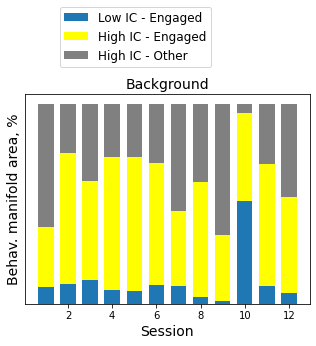

In [112]:
x_vals = np.arange(len(areas)) + 1

fig, ax = plt.subplots(1, 1, figsize=(4.5, 5))

ex1 = areas[:, 1] / areas[:, 3]
ex2 = areas[:, 0] / areas[:, 3]
intrs = areas[:, 2] / areas[:, 3]
rects1 = ax.bar(x_vals, ex1, 0.7, label='Low IC - Engaged', color='tab:blue')
rects2 = ax.bar(x_vals, intrs, 0.7, bottom=ex1, label='High IC - Engaged', color='yellow')
rects2 = ax.bar(x_vals, ex2, 0.7, bottom=ex1 + intrs, label='High IC - Other', color='gray')
ax.legend(bbox_to_anchor=(0.1, 1.1), fontsize=12)
ax.set_title('Background', fontsize=14)
ax.set_xlabel('Session', fontsize=14)
ax.set_yticks([])
    
ax.set_ylabel('Behav. manifold area, %', fontsize=14)
fig.tight_layout()

In [113]:
fig.savefig(os.path.join(report, 'showroom', 'bMAP_high_IC_overlaps_cross-session.png'), dpi=300)

### 1. look at single units psth at AL / other states
### 2. Signal to noise ratio in diff (behav) states
### 3. Test that behavior at successful target entrance is the same and lasts for the time stayed in the island
### 4. Syllable profiles - are they constant across sessions for each animal? Between animals?
### 5. Predict the W4 from the syllables - should be the same syllables as given by averaging the AL group
### 6. Perception is not action -> show that AL state can happen in other behavioral states

### 7. Do UMAP of W1-W4 and color behav states there, also color speed


In [51]:
patches = get_field_patches(d_map, 0.2)

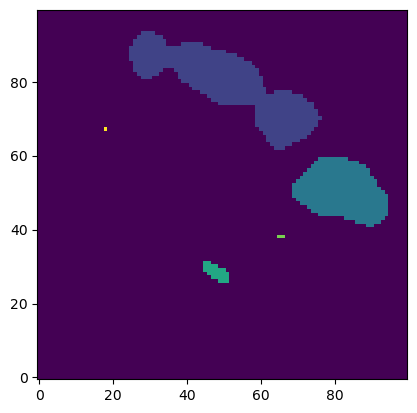

In [52]:
plt.imshow(patches.T, origin='lower')

In [54]:
idxs_in = get_idxs_in_patches(fit, patches, extent)

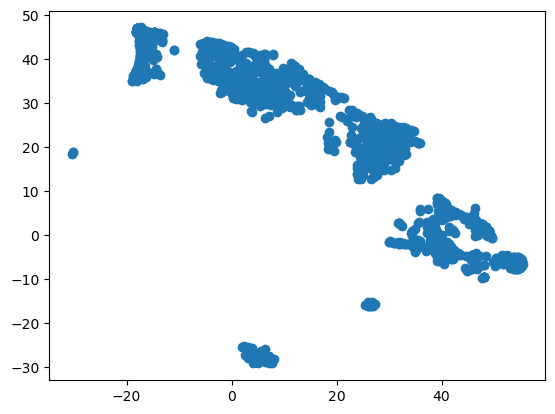

In [55]:
plt.scatter(fit[idxs_in][:, 0], fit[idxs_in][:, 1])

In [56]:
w_pca = activity_at_phase(s_path, 4, do_pca=True)
w_int = np.interp(tl[idxs_srm_tl][:, 0], events[:, 0], w_pca)

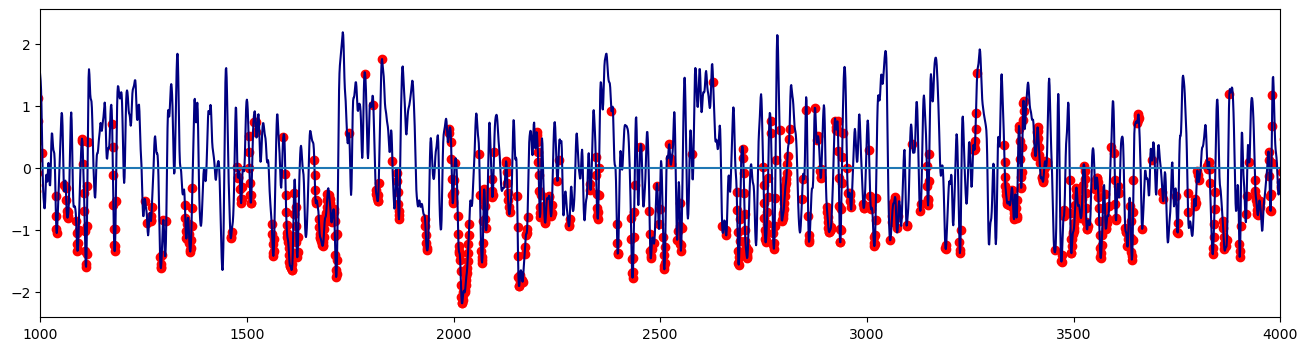

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))

x_l, x_r = 1000, 4000

x_vals = np.arange(len(w_int))
ax.plot(x_vals, w_int, color='navy')
ax.scatter(x_vals[idxs_in], w_int[idxs_in], color='red')
ax.set_xlim(x_l, x_r)
ax.axhline(w_int.mean())